<a href="https://colab.research.google.com/github/MohamedAfham/COVID-19-Cough-Detection/blob/master/COVID_Cough_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import librosa
from scipy.io import wavfile
import matplotlib.pyplot as plt
from IPython.display import Audio
import numpy as np
import scipy
#import seaborn as sns
import random
import math
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix, classification_report

#import tensorflow.compat.v1 as tf
import tensorflow as tf
#tf.enable_eager_execution()
#tf.disable_v2_behavior()
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation,ReLU,LeakyReLU
from tensorflow.keras.models import load_model
#from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler,Callback

In [0]:
#!mkdir FSDKaggle
#!unzip '/content/drive/My Drive/Cough Detection Project/Sounds.zip'
#!wget "https://zenodo.org/record/2552860/files/FSDKaggle2018.audio_train.zip?download=1" 
#!unzip 'FSDKaggle2018.audio_train.zip?download=1'
#!wget "https://zenodo.org/record/2552860/files/FSDKaggle2018.meta.zip?download=1" 
#!unzip "/content/FSDKaggle2018.meta.zip?download=1"
#!mv "/content/Non_Cough/non_cough.zip" "/content/"
#!cp -r "/content/drive/My Drive/Cough Detection Project/Non_Cough/" "/content/"  
#!cp "/content/Pre trained Models/"* "/content/drive/My Drive/Cough Detection Project/Pre trained Models/"
#!unzip "/content/non_cough.zip" -d "/content/Non_Cough/"

In [0]:
train = pd.read_csv("/content/FSDKaggle2018.meta/train_post_competition.csv")

coughs = train[train['label']=="Cough"]['fname'].tolist()
non_coughs = train[train['label']!="Cough"]['fname'].tolist()

In [0]:
def read_audio(audio_directory,audio_file):
  audio,sampling_rate = librosa.load(audio_directory+audio_file)
  return (audio,sampling_rate)

def volume_aug(audio):
  factor_list = [0.5,1,1.5,2]
  factor = factor_list[np.random.randint(0,4)]
  augmented_samples = audio * factor
  return augmented_samples

def bg_noise_aug(audio,bg_noise):
  length = len(audio)
  rand_start = np.random.randint(0,len(bg_noise)- length)
  augmented_audio = audio + bg_noise[rand_start:rand_start + length]
  return augmented_audio

def spect(audio):
  NFFT = 512
  f, t, Sxx = scipy.signal.spectrogram(x=audio,fs=sampling_rate,window=np.hamming(NFFT),nfft=NFFT,noverlap=int(NFFT/3),nperseg=NFFT,mode='magnitude')
  spectrum = 20*np.log10(Sxx)
  spectrum = spectrum.ravel().reshape(257,321,1)
  return spectrum

def melspectrogram(audio,sampling_rate):  #no of mels means no of mel filters
  #samples, sampling_rate = librosa.core.load(directory + audio_file)   #loading data set
  samples = audio
  frame_size = 0.025
  frame_stride = frame_size * 0.7
  no_of_mels = 128
  frame_length, frame_step = frame_size * sampling_rate, frame_stride * sampling_rate  
  frame_length = int(round(frame_length))
  frame_step = int(round(frame_step))
  samples_length = len(samples)
  num_frames = int(np.ceil(float(np.abs(samples_length - frame_length)) / frame_step))

  pad_samples_length = num_frames * frame_step + frame_length
  z = np.zeros((pad_samples_length - samples_length))
  pad_samples = np.append(samples, z)  #zero padding
      
  spect_samples = np.abs(librosa.stft(pad_samples, n_fft=frame_length, hop_length=frame_step, window=np.hamming(frame_length))) #calculating stft 
  spect_samples = librosa.amplitude_to_db(spect_samples, ref=np.max)
  mel_filter = librosa.filters.mel(sampling_rate, frame_length, n_mels=128, fmin=0, fmax=None)  #calculating mel filter array
  
  mel_spect_samples = np.dot(mel_filter, spect_samples)   #calculating mel spectrogram
  spectrum = mel_spect_samples.ravel().reshape(128,287,1)
  #spectrum = mel_spect_samples
  return spectrum

def normalize_spectrum(spectrum):
  return (spectrum - np.mean(spectrum))/np.std(spectrum)

In [0]:
bg_noise_dir = ['Station.wav','NeighbourSpeaking.wav','Metro.wav','Hallway.wav','FootSteps.wav','AirportAnnouncements.wav']
audio_directory = '/content/Sounds_up/Background Noise/'
bg_noise_list = []
for noise in range(len(bg_noise_dir)):
  audio_file = bg_noise_dir[noise]
  noise_add = read_audio(audio_directory,audio_file)[0]
  bg_noise_list.append(noise_add)

In [28]:
import os
audio_directory = "/content/Non_Cough/"
non_cough_FSD = os.listdir("/content/Non_Cough/")
non_cough_up = os.listdir("/content/Sounds_up/Non Cough/")
cough = os.listdir("/content/Sounds_up/Cough/")
non_cough = non_cough_FSD
print (len(non_cough_FSD))
print (len(non_cough_up))
print(len(non_cough))
print (len(cough))
print (non_cough[1][-4:])

14132
391
14132
469
.wav


non_cough


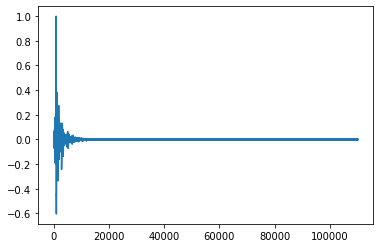

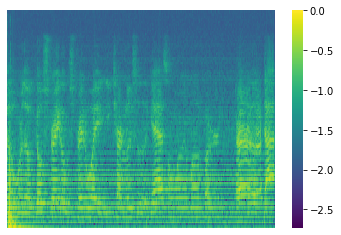

In [35]:
import seaborn as sns
label = np.random.randint(0,2)
if label == 1:
  audio_directory = "/content/Sounds_up/Cough/"
else:
  audio_directory = "/content/Non_Cough/"
rand_audio = random.choice(train_files[label])
#sampling_rate, selected_audio = wavfile.read(audio_directory+rand_audio)
selected_audio,sampling_rate = read_audio(audio_directory,rand_audio)
#print (len(selected_audio))

if len(selected_audio) != 110250:
  length = int(5.0 * sampling_rate)
  audio = librosa.util.fix_length(selected_audio,length)
  noise = np.random.randn(len(audio)) * 0.0005
  selected_audio = audio + noise

volume_aug_audio = volume_aug(selected_audio)
rand_noise = random.randrange(len(bg_noise_list))
bg_noise = bg_noise_list[rand_noise]
bg_noise_added = bg_noise_aug(volume_aug_audio,bg_noise)
spectrum = melspectrogram(bg_noise_added,sampling_rate)
#spectrum = normalize_spectrum(spectrum)

plt.plot(selected_audio)
spectrum = np.squeeze(spectrum)

if label==1:
  print ("cough")
else:
  print ("non_cough")

fig,ax = plt.subplots()
sns.heatmap(spectrum,cmap='viridis',xticklabels=False,yticklabels=False,ax = ax)
ax.invert_yaxis()
plt.show()
plt.close()

In [34]:
k = 1
for name in non_cough:
  print(k,end=" ")
  if name[-4:] != ".wav":
    print (name)
    break
  k+=1

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 

In [0]:
test_cough = random.sample(cough,45)
test_non_cough = random.sample(non_cough,45)

train_val_cough = list(set(cough) - set(test_cough))
train_val_non_cough = list(set(non_cough) - set(test_non_cough))


random.shuffle(train_val_cough)
#train_val_cough = train_val_cough[100:400]
train_cough,val_cough = train_val_cough[:int(len(train_val_cough)*0.9)], train_val_cough[int(len(train_val_cough)*0.9):]

random.shuffle(train_val_non_cough)
#train_val_non_cough = train_val_non_cough[1500:1800]
train_non_cough,val_non_cough = train_val_non_cough[:int(len(train_val_non_cough)*0.9)], train_val_non_cough[int(len(train_val_non_cough)*0.9):]

train_files = [train_non_cough, train_cough]
val_files = [val_non_cough, val_cough]

In [30]:
len(train_files[0])+len(train_files[1])

13059

In [31]:
batch_size = 12
steps_epoch = int((len(train_files[0])+len(train_files[1]))/batch_size)
val_steps = int((len(val_files[0])+len(val_files[1]))/batch_size)
print (steps_epoch)
print (val_steps)

1088
121


In [0]:
sampling_rate = 22050
def generator(batch_size, is_train):
  if is_train:
    audio_list = train_files
  else:
    audio_list = val_files

  #while True:
  batch_features = np.zeros((batch_size,128,287,1))
  batch_labels = np.zeros((batch_size,1))
  rand_list = [[],[]]
  for n in range(batch_size):
    #print ("Hi")
    label = np.random.randint(0,2)
    if label == 1:
      audio_directory = "/content/Sounds_up/Cough/"
    else:
      audio_directory = "/content/Non_Cough/"
    rand_audio = random.choice(audio_list[label])
    #sampling_rate, selected_audio = wavfile.read(audio_directory+rand_audio)
    selected_audio,sampling_rate = read_audio(audio_directory,rand_audio)
    #print (len(selected_audio))
    
    if len(selected_audio) != 110250:
      length = int(5.0 * sampling_rate)
      audio = librosa.util.fix_length(selected_audio,length)
      noise = np.random.randn(len(audio)) * 0.0005
      selected_audio = audio + noise

    volume_aug_audio = volume_aug(selected_audio)
    rand_noise = random.randrange(len(bg_noise_list))
    bg_noise = bg_noise_list[rand_noise]
    bg_noise_added = bg_noise_aug(volume_aug_audio,bg_noise)
    spectrum = melspectrogram(bg_noise_added,sampling_rate)
    batch_features[n] = normalize_spectrum(spectrum)
    batch_labels[n] = label

  return  batch_features,batch_labels

In [20]:
batch_features,batch_labels = generator(15, True)
batch_features.shape

(15, 128, 287, 1)

In [22]:
# Generator Function
sampling_rate = 22050
def generator(batch_size, is_train):
  if is_train:
    audio_list = train_files
  else:
    audio_list = val_files

  while True:
    batch_features = np.zeros((batch_size,128,287,1))
    batch_labels = np.zeros((batch_size,1))
    rand_list = [[],[]]
    for n in range(batch_size):
      #print ("Hi")
      label = np.random.randint(0,2)
      if label == 1:
        audio_directory = "/content/Sounds_up/Cough/"
      else:
        audio_directory = "/content/Non_Cough/"
      rand_audio = random.choice(audio_list[label])
      #sampling_rate, selected_audio = wavfile.read(audio_directory+rand_audio)
      selected_audio,sampling_rate = read_audio(audio_directory,rand_audio)
      #print (len(selected_audio))
      
      if len(selected_audio) != 110250:
        length = int(5.0 * sampling_rate)
        audio = librosa.util.fix_length(selected_audio,length)
        noise = np.random.randn(len(audio)) * 0.0005
        selected_audio = audio + noise

      volume_aug_audio = volume_aug(selected_audio)
      rand_noise = random.randrange(len(bg_noise_list))
      bg_noise = bg_noise_list[rand_noise]
      bg_noise_added = bg_noise_aug(volume_aug_audio,bg_noise)
      spectrum = melspectrogram(bg_noise_added,sampling_rate)
      batch_features[n] = spectrum
      batch_labels[n] = label

    yield batch_features,batch_labels

#Callbacks
trained_model_path_Adam = '/content/Pre trained Models/model-{accuracy:.2f}-Adam.h5'
checkpoint_Adam = ModelCheckpoint(trained_model_path_Adam, 
                             monitor='accuracy', 
                             save_best_only=True, 
                             mode='max', 
                             period=1)

trained_model_path_SGD= '/content/Pre trained Models/model-{accuracy:.2f}-SGD.h5'
checkpoint_SGD = ModelCheckpoint(trained_model_path_SGD, 
                             monitor='accuracy', 
                             save_best_only=True, 
                             mode='max', 
                             period=1)

early_stop = EarlyStopping(monitor='accuracy', 
                           min_delta=0.001, 
                           patience=30, 
                           mode='max',
                           restore_best_weights=False)

def step_decay(epoch):
   initial_rate = 0.01
   drop = 0.5
   epochs_drop = 10.0
   lrate = initial_rate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
   return lrate

step_scheduler  = LearningRateScheduler(step_decay)

#Model 
shape = (128,287,1)
model = Sequential()

#Layer 1 
model.add(MaxPooling2D(pool_size=(2,2),input_shape=shape,name='MaxPooling2D_1'))
model.add(Conv2D(32, kernel_size=(5,5),padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(4,4)))

#Layer 2
model.add(Conv2D(64, kernel_size=(5,5),padding='same',name='Conv2D_2'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2,2),name='MaxPooling2D_3'))

model.add(Flatten(name = 'Flatten'))

#Layer 3
#model.add(Dense(256,name = 'Dense_1'))
#model.add(BatchNormalization(name = 'BatchNormalization_2'))
#model.add(LeakyReLU(alpha=0.1))
#model.add(Dropout(0.5,name = 'Dropout_1'))

#Layer 4
model.add(Dense(128,name = 'Dense_2'))
model.add(BatchNormalization(name = 'BatchNormalization_3'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5,name = 'Dropout_2'))

#Layer 5
model.add(Dense(128,name = 'Dense_3'))
model.add(BatchNormalization(name = 'BatchNormalization_4'))
model.add(LeakyReLU(alpha=0.1))
#model.add(Dropout(0.5,name = 'Dropout_3'))

model.add(Dense(1,activation='sigmoid',name = 'Dense_4'))

adam = keras.optimizers.Adam(learning_rate =1e-2, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(optimizer= adam, loss='binary_crossentropy', metrics=['accuracy'])
batch_size = 12
history = model.fit(generator(batch_size,True), epochs=150,steps_per_epoch=50,callbacks=[step_scheduler,early_stop,checkpoint_Adam])
#x = model.optimizer.lr
#tf.print(x)

Epoch 1/150
50/50 [==============================] - 256s 5s/step - loss: 0.5530 - accuracy: 0.7533 - lr: 0.0100
Epoch 2/150
50/50 [==============================] - 251s 5s/step - loss: 0.4185 - accuracy: 0.8017 - lr: 0.0100
Epoch 3/150
50/50 [==============================] - 250s 5s/step - loss: 0.3778 - accuracy: 0.8417 - lr: 0.0100
Epoch 4/150
50/50 [==============================] - 248s 5s/step - loss: 0.3222 - accuracy: 0.8583 - lr: 0.0100
Epoch 5/150
50/50 [==============================] - 249s 5s/step - loss: 0.3114 - accuracy: 0.8717 - lr: 0.0100
Epoch 6/150
50/50 [==============================] - 249s 5s/step - loss: 0.3191 - accuracy: 0.8633 - lr: 0.0100
Epoch 7/150
50/50 [==============================] - 253s 5s/step - loss: 0.3100 - accuracy: 0.8650 - lr: 0.0100
Epoch 8/150
50/50 [==============================] - 254s 5s/step - loss: 0.2961 - accuracy: 0.8817 - lr: 0.0100
Epoch 9/150
50/50 [==============================] - 252s 5s/step - loss: 0.2716 - accuracy: 0.8

UnknownError: ignored